<a href="https://colab.research.google.com/github/jagadeeshreddyr/Book-Management-System/blob/main/crop_yield_w_s_cnn_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout, Input, Concatenate, Conv1D, MaxPooling1D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns


plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('/content/train_1.csv')
season_mapping = {'Kharif': 0, 'Rabi': 1}
data['Season'] = data['Season'].map(season_mapping)
data.columns

Index(['Year', 'Season', 'total_Rainfall', 'Wind Speed', 'Temperature (°C)',
       'NDVI', 'LST', 'rsm', 'Relative Humidity', 'Yield (Tonnes/Hectare)'],
      dtype='object')

In [ ]:
def error(df: pd.DataFrame, x: str, y: str) -> tuple[float, float, float, float, float]:
    """
    this is to calculate the error

    Parameters
    ----------
    df : Dataframe
         This df contains dataframe contains predicted and actual yield

    x: str

        actual yield value column name

    y: str

        predicated yield value column name

    Returns
    -------
        mae = Mean absoulte error
        mse = Mean squared error
        var = Variance in model
        corr = correlation of model
        bias = Bias of the model
        r2 = Coefficient of determination
    """

    mae = mean_absolute_error(df[x], df[y]).round(2)
    mse = mean_squared_error(df[x], df[y]).round(2)
    var = df[y].var().round(2)
    corr = round(df[x].corr(df[y]), 2)
    bias = (df[x] - df[y]).sum() / (df[y].sum()) * 100
    r2 = r2_score(df[x], df[y]).round(3)


    print(f'mae = {mae}, mse = {mse}, variance = {var}, corr = {corr}, bias = {bias}, r2 = {r2}')
    # return mae, mse, var, corr, bias, r2

In [ ]:
data.columns

Index(['Year', 'Season', 'total_Rainfall', 'Wind Speed', 'Temperature (°C)',
       'NDVI', 'LST', 'rsm', 'Relative Humidity', 'Yield (Tonnes/Hectare)'],
      dtype='object')

Extract features and target variable

In [ ]:
# X = data[['NDVI', 'LST', 'rsm', 'Temperature (°C)', 'total_Rainfall', 'Relative Humidity', 'Wind Speed']].values
X = data[['NDVI', 'LST', 'rsm','Season' ,'Temperature (°C)', 'total_Rainfall', 'Relative Humidity', 'Wind Speed']]
y = data['Yield (Tonnes/Hectare)'].values

In [ ]:
# season_mapping = {0: 'Kharif', 1: 'Rabi'}

# for sea in [0,1]:

#   sea_df = data.loc[data['Season']==sea]

#   fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')

#   sns.histplot(sea_df['Yield (Tonnes/Hectare)'], kde=True)
#   plt.title(season_mapping[sea])

Normalize features

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Reshape data for CNN

In [ ]:
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1], 1)
X_reshaped.shape

(38, 1, 8, 1)

In [ ]:
X_reshaped.shape

(38, 1, 8, 1)

Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

Split the data into weather and satellite components

In [ ]:
val = 4
X_weather = X_train[:, :, val:, :]
X_satellite = X_train[:, :, :val, :]

X_test_wea = X_test[:, :, val:, :]
X_test_sat = X_test[:, :, :val, :]

X_test_wea.shape, X_test_sat.shape

((8, 1, 4, 1), (8, 1, 4, 1))

--- Weather CNN Model ---

In [ ]:
in1 = 4

weather_model = Sequential()
weather_model.add(Conv2D(in1, (1, X_weather.shape[2]),activation='relu', input_shape= (1,X_weather.shape[2], 1)))  # Using Conv2D with appropriate kernel size
weather_model.add(MaxPooling2D((1, 1)))
weather_model.add((Conv2D(8,(1,1), activation='relu')))
weather_model.add(MaxPooling2D((1, 1)))
weather_model.add((Conv2D(4,(1,1), activation='relu')))
weather_model.add(MaxPooling2D((1, 1)))
weather_model.add(Flatten())



--- Satellite CNN Model ---

In [ ]:
satellite_model = Sequential()
satellite_model.add(Conv2D(in1, (1, X_satellite.shape[2]), activation='relu', input_shape=(1, X_satellite.shape[2], 1)))
satellite_model.add(MaxPooling2D((1, 1)))
satellite_model.add((Conv2D(8,(1,1), activation='relu')))
satellite_model.add(MaxPooling2D((1, 1)))
satellite_model.add((Conv2D(4,(1,1), activation='relu')))
satellite_model.add(MaxPooling2D((1, 1)))
satellite_model.add(Flatten())

Concatenate the outputs of the CNN models

In [ ]:
combined_input = Concatenate()([weather_model.output, satellite_model.output])

--- RNN Model ---

In [ ]:
rnn_model = Sequential()
rnn_model.add(LSTM(50, activation='relu', input_shape=(combined_input.shape[1], 1)))

Dense layers

In [ ]:
rnn_model.add(Dense(50,activation='relu'))
rnn_model.add(Dense(1, activation='relu'))  # Output layer

Combined Model

In [ ]:
combined_model = None

In [ ]:
combined_input.shape

TensorShape([None, 8])

In [ ]:
combined_model = Model(inputs=[weather_model.input, satellite_model.input], outputs=rnn_model(combined_input))

Compile the model

In [ ]:
combined_model.compile(optimizer='adam', loss='mse')  # You can use other optimizers and loss functions based on your task

Train the model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = combined_model.fit([X_weather, X_satellite], y_train, epochs=20, batch_size=1, validation_split=0.1, callbacks=[early_stopping]  )

Epoch 1/20
27/27 [==============================] - 4s 31ms/step - loss: 9.4766 - val_loss: 6.6478
Epoch 2/20
27/27 [==============================] - 0s 11ms/step - loss: 5.1976 - val_loss: 2.1854
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.8106 - val_loss: 0.6614
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.5894 - val_loss: 0.4884
Epoch 5/20
27/27 [==============================] - 0s 6ms/step - loss: 0.3855 - val_loss: 0.5629
Epoch 6/20
27/27 [==============================] - 0s 7ms/step - loss: 0.3535 - val_loss: 0.3452
Epoch 7/20
27/27 [==============================] - 0s 7ms/step - loss: 0.3221 - val_loss: 0.4091
Epoch 8/20
27/27 [==============================] - 0s 7ms/step - loss: 0.4463 - val_loss: 0.2263
Epoch 9/20
27/27 [==============================] - 0s 6ms/step - loss: 0.4072 - val_loss: 0.1962
Epoch 10/20
27/27 [==============================] - 0s 7ms/step - loss: 0.3352 - val_loss: 0.1952
Epoch 11/20
27/27

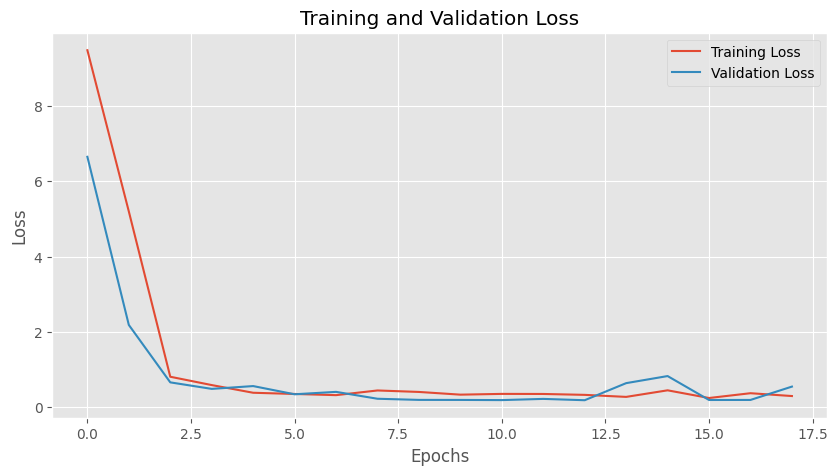

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Evaluate the model

In [ ]:
loss = combined_model.evaluate([X_test_wea, X_test_sat], y_test)
print(f'Mean Squared Error on Test Data: {loss}')

1/1 [==============================] - 0s 295ms/step - loss: 0.2978
Mean Squared Error on Test Data: 0.2978200912475586


Make predictions

In [ ]:

predictions = combined_model.predict([X_test_wea, X_test_sat])
predictions

1/1 [==============================] - 0s 265ms/step


array([[2.79486  ],
       [2.8953876],
       [2.9021487],
       [2.8422666],
       [2.7489707],
       [2.8435907],
       [2.8894813],
       [2.9445462]], dtype=float32)

Text(0.5, 1.0, 'Actual vs Predicted')

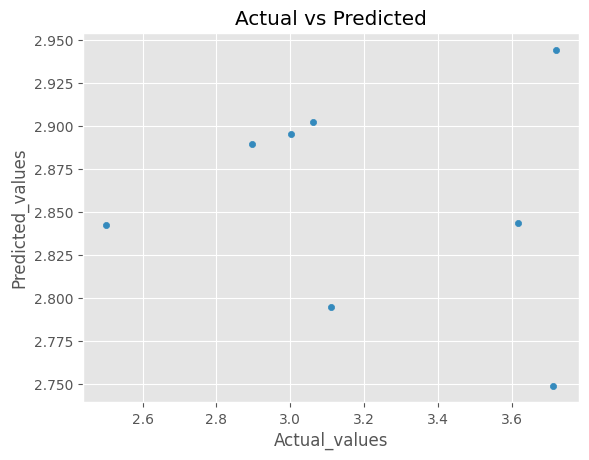

In [ ]:
error_df = pd.DataFrame([y_test, predictions.flatten()]).T
error_df.columns = ['Actual_values', 'Predicted_values']
error_df.plot.scatter('Actual_values', 'Predicted_values')
plt.title('Actual vs Predicted')

In [ ]:

error(error_df, 'Actual_values', 'Predicted_values')

mae = 0.36, mse = 0.18, variance = 0.0, corr = -0.3, bias = 1.1132765903731543, r2 = -0.054


In [ ]:
predictions_train = combined_model.predict([X_train[:, :, :3, :], X_train[:, :, 3:, :]])

1/1 [==============================] - 0s 317ms/step


In [ ]:
X_train.shape

(30, 1, 8, 1)

Text(0.5, 1.0, 'Actual vs Predicted Train')

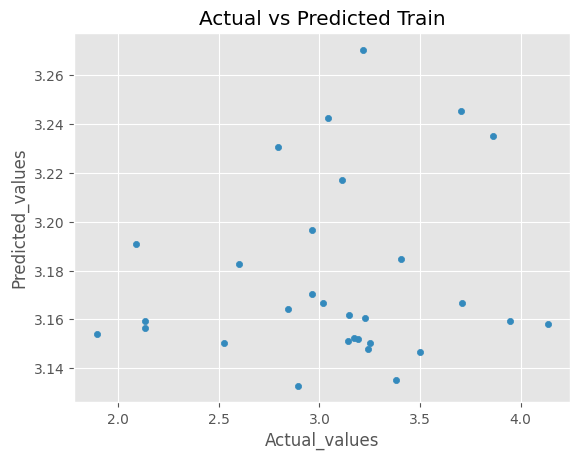

In [ ]:
error_df = pd.DataFrame([y_train, predictions_train.flatten()]).T
error_df.columns = ['Actual_values', 'Predicted_values']
error_df.plot.scatter('Actual_values', 'Predicted_values')
plt.title('Actual vs Predicted Train')

In [ ]:
error(error_df, 'Actual_values', 'Predicted_values')

mae = 0.4, mse = 0.3, variance = 0.0, corr = 0.12, bias = -3.212745157981934, r2 = -0.024


In [ ]:
import pickle

In [ ]:
with open(f"main_1.pkl", 'wb') as src:
      pickle.dump(combined_model, src, protocol=3)



In [ ]:
with open(f"main_slr.pkl", 'wb') as src:
      pickle.dump(scaler, src, protocol=3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define a simple neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 9.7544 - mae: 3.0761 - val_loss: 9.9183 - val_mae: 3.1018
Epoch 2/100
1/1 [==============================] - 0s 72ms/step - loss: 9.6233 - mae: 3.0550 - val_loss: 9.8054 - val_mae: 3.0835
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 9.5297 - mae: 3.0396 - val_loss: 9.6960 - val_mae: 3.0657
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 9.4634 - mae: 3.0285 - val_loss: 9.5892 - val_mae: 3.0482
Epoch 5/100
1/1 [==============================] - 0s 62ms/step - loss: 9.3104 - mae: 3.0033 - val_loss: 9.4853 - val_mae: 3.0310
Epoch 6/100
1/1 [==============================] - 0s 57ms/step - loss: 9.2263 - mae: 2.9891 - val_loss: 9.3840 - val_mae: 3.0142
Epoch 7/100
1/1 [==============================] - 0s 42ms/step - loss: 9.1638 - mae: 2.9786 - val_loss: 9.2852 - val_mae: 2.9976
Epoch 8/100
1/1 [==============================] - 0s 41ms/step - loss: 9.1273 - mae: 2.9724

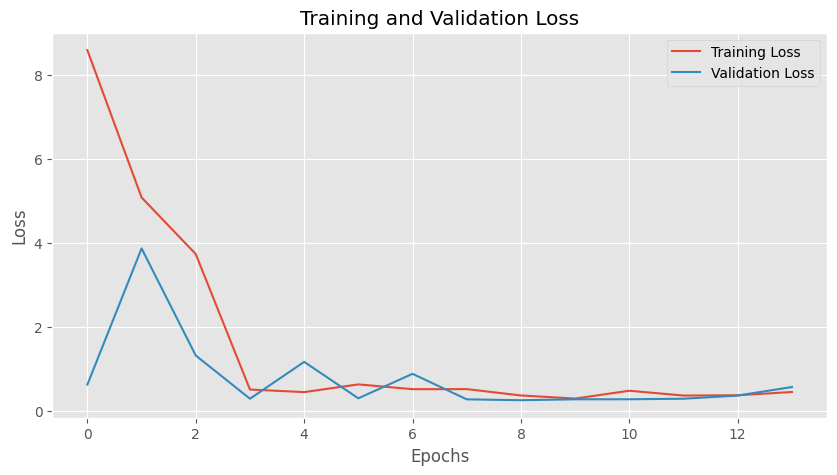

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('train_1.csv')

# Encode categorical variables
season_mapping = {'Kharif': 0, 'Rabi': 1}
data['Season'] = data['Season'].map(season_mapping)

# Select features and target
X = data[['NDVI', 'LST', 'rsm', 'Season', 'Temperature (°C)', 'total_Rainfall', 'Relative Humidity', 'Wind Speed']]
y = data['Yield (Tonnes/Hectare)']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2 ): {r2}')


Mean Absolute Error (MAE): 0.35075400638143767
Mean Squared Error (MSE): 0.14363904773559044
R-squared (R2 ): 0.15280072671021738


Text(0.5, 1.0, 'Actual vs Predicted')

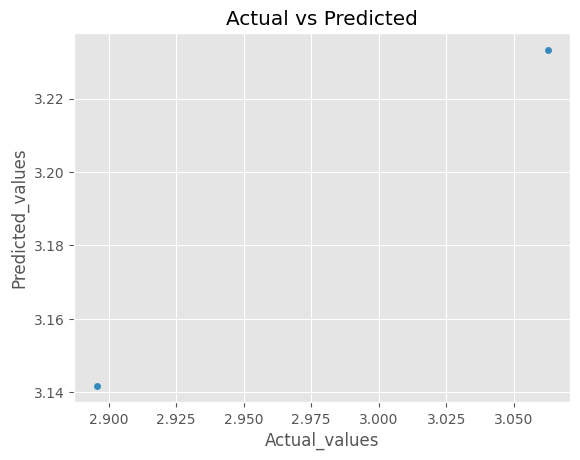

In [ ]:
error_df = pd.DataFrame([y_test, y_pred]).T
error_df.columns = ['Actual_values', 'Predicted_values']
error_df.plot.scatter('Actual_values', 'Predicted_values')
plt.title('Actual vs Predicted')